In [27]:
import sys 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

## keras
from tensorflow_core.python.keras import Input, Model
from tensorflow_core.python.keras.layers import Dropout, Dense, Attention, LSTM

from numpy.matlib import repmat
import pandas as pd
import sklearn
import math

In [28]:
#数据预处理
path = r'C:\Users\zzsgdsg7\Desktop\2021年B题\附件1 监测点A空气质量预报基础数据2.xls'

data = pd.read_excel(path)
data.iloc[:,0] = pd.to_datetime(data.iloc[:,0])
data.set_axis(['time', 'place', 'so2','no2','pm10', 'pm2.5', 'o3','co','temperature', 'humidity', 'pressure','wind','direction'], axis='columns',inplace=True)
#print(data.head())

#数据基本处理
modeltime = data['time']
data = data.drop(columns=['place','time'])
data= data.replace('—', np.nan)
data = data.astype('float')
data[ data< 0 ] = np.nan
print(data.head())
data.insert(0,'time',modeltime)#重新插入时间列

#KNN插值

data_knn =data

def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):#判断值是否是空
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

for indexs in data.columns:
    if indexs =='time':
        continue
    data_knn[indexs] = knn_mean(data_knn[indexs].values,24)

    
data_knn=pd.DataFrame(data_knn).set_index('time')

   so2   no2  pm10  pm2.5    o3   co  temperature  humidity  pressure  wind  \
0  5.0  75.0  61.0   38.0   1.0  1.0         21.1      89.0    1013.0   1.2   
1  5.0  64.0  60.0   41.0  25.0  0.8         20.4      92.0    1012.4   1.1   
2  4.0  60.0  36.0   40.0  25.0  0.8         20.0      93.0    1011.3   1.1   
3  4.0  39.0  35.0   33.0  41.0  0.7         19.8      93.0    1010.4   1.5   
4  4.0  39.0  28.0   39.0  36.0  0.8         19.9      92.0    1010.0   1.5   

   direction  
0      346.5  
1       18.0  
2       65.9  
3       78.4  
4       73.5  


In [29]:
data_knn.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19432 entries, 2019-04-16 00:00:00 to 2021-07-13 07:00:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   so2          19432 non-null  float64
 1   no2          19432 non-null  float64
 2   pm10         19432 non-null  float64
 3   pm2.5        19432 non-null  float64
 4   o3           19432 non-null  float64
 5   co           19432 non-null  float64
 6   temperature  19432 non-null  float64
 7   humidity     19432 non-null  float64
 8   pressure     19432 non-null  float64
 9   wind         19432 non-null  float64
 10  direction    19432 non-null  float64
dtypes: float64(11)
memory usage: 1.8 MB


In [30]:
data_knn.shape


(19432, 11)

In [31]:
data_knn.describe()

,so2,no2,pm10,pm2.5,o3,co,temperature,humidity,pressure,wind,direction
count,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000,19432.000000
mean,6.989639,32.914363,44.085735,23.678415,54.356035,0.717653,25.010925,69.252999,1010.578566,1.381130,154.478188
std,3.684391,23.949104,27.320966,18.314230,50.634230,0.237688,5.733298,16.155686,6.491555,0.671542,117.651562
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.100000,5.800000,14.000000,993.500000,0.100000,0.000000
25%,5.000000,16.000000,24.534091,10.000000,18.000000,0.600000,21.000000,60.000000,1005.300000,0.900000,49.200000
50%,6.000000,27.000000,38.000000,19.000000,41.000000,0.700000,26.100000,71.000000,1010.000000,1.300000,108.600000
75%,9.000000,42.000000,58.000000,33.000000,76.000000,0.800000,29.400000,81.000000,1015.600000,1.800000,256.100000
max,47.000000,211.000000,217.000000,163.000000,405.000000,2.500000,38.200000,99.000000,1029.200000,5.800000,360.000000


数据可视化分析
下面对一天中的数据进行了重采样，并显示了so2的总和和平均值。可以看出，重采样数据集的平均值和总和具有相似的结构。

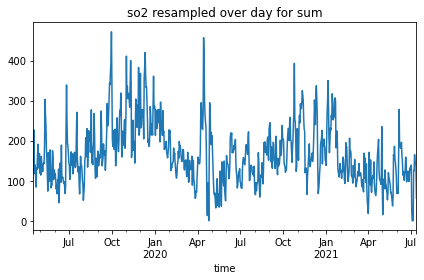

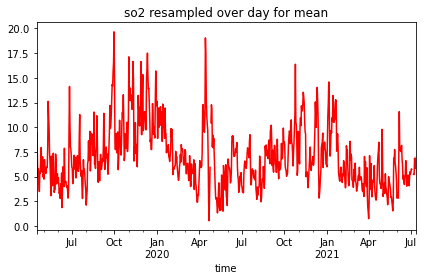

In [32]:
data_knn.so2.resample('D').sum().plot(title = 'so2 resampled over day for sum')
plt.tight_layout()
plt.show()

data_knn.so2.resample('D').mean().plot(title='so2 resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

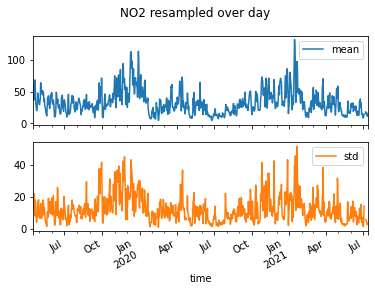

In [33]:
### 下面展示了一天内重新采样的“no2”的平均值和标准差
r = data_knn.no2.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='NO2 resampled over day')
plt.show()

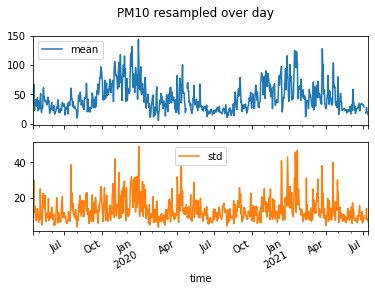

In [34]:
### 下面展示了一天内重新采样的“PM10”的平均值和标准差
r = data_knn.pm10.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='PM10 resampled over day')
plt.show()

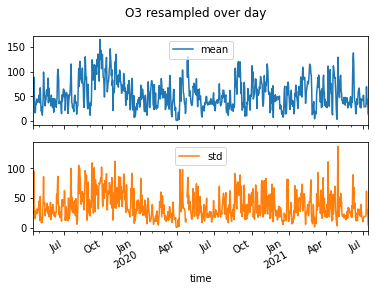

In [35]:
### 下面展示了一天内重新采样的“O3”的平均值和标准差
r = data_knn.o3.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='O3 resampled over day')
plt.show()

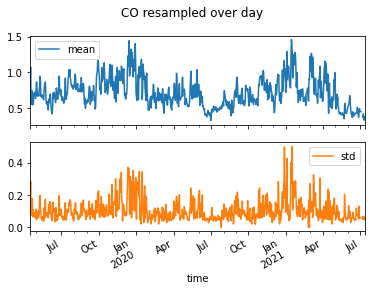

In [36]:
### 下面展示了一天内重新采样的“CO”的平均值和标准差
r = data_knn.co.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='CO resampled over day')
plt.show()

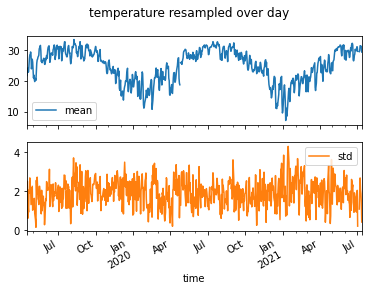

In [37]:
### 下面展示了一天内重新采样的“temperature”的平均值和标准差
r = data_knn.temperature.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='temperature resampled over day')
plt.show()

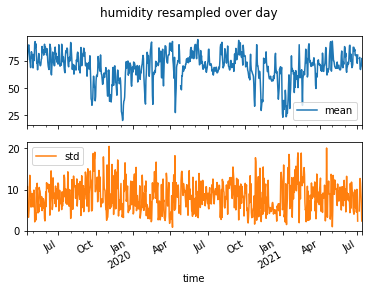

In [38]:
### 下面展示了一天内重新采样的“humidity”的平均值和标准差
r = data_knn.humidity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='humidity resampled over day')
plt.show()

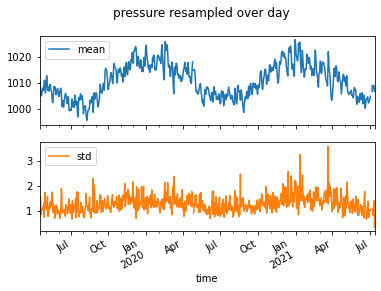

In [39]:
### 下面展示了一天内重新采样的“pressure”的平均值和标准差
r = data_knn.pressure.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='pressure resampled over day')
plt.show()

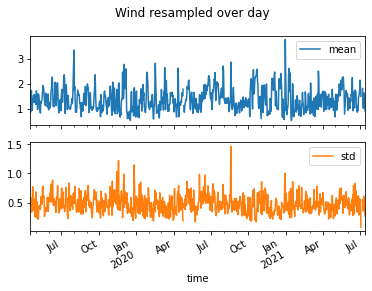

In [40]:
### 下面展示了一天内重新采样的“wind”的平均值和标准差
r = data_knn.wind.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Wind resampled over day')
plt.show()

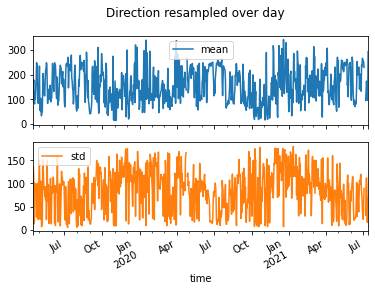

In [41]:
### 下面展示了一天内重新采样的“direction”的平均值和标准差
r = data_knn.direction.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Direction resampled over day')
plt.show()

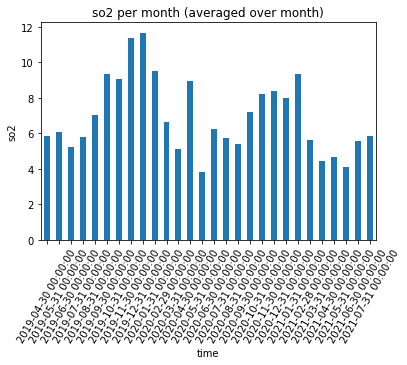

In [42]:
### 当月重新采样的“so2”总和
data_knn['so2'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('so2')
plt.title('so2 per month (averaged over month)')
plt.show()

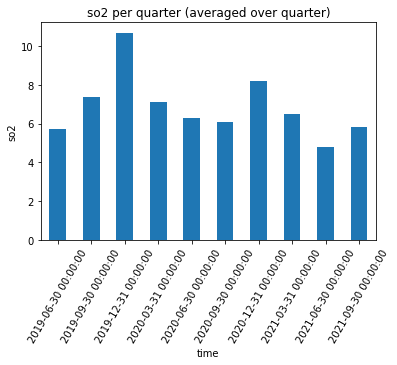

In [43]:
## 四分之一季度内“so2”的平均值
data_knn['so2'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('so2')
plt.title('so2 per quarter (averaged over quarter)')
plt.show()

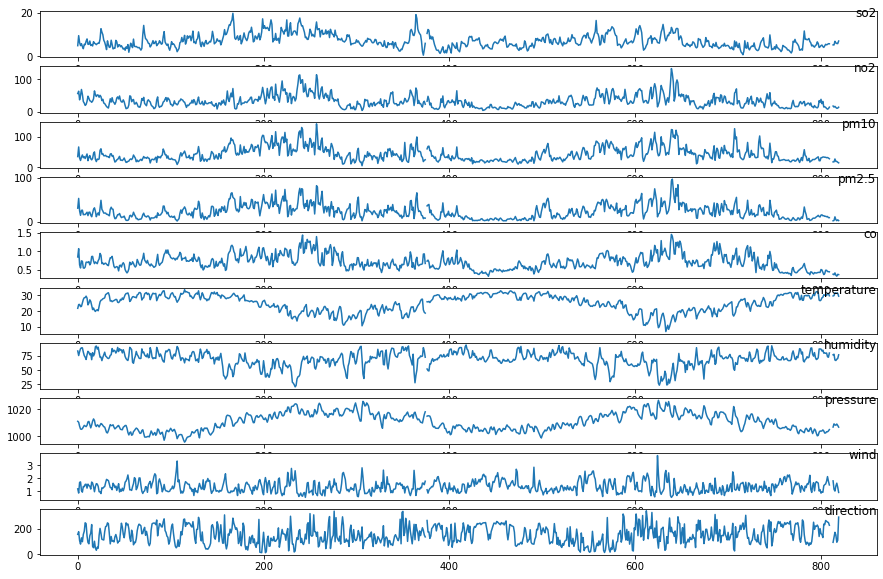

In [44]:
# 下面比较了一天中不同特征的平均值
# 绘制指定的列
cols = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
i = 1
groups=cols
values = data_knn.resample('D').mean().values
# 绘制每一列
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(data_knn.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

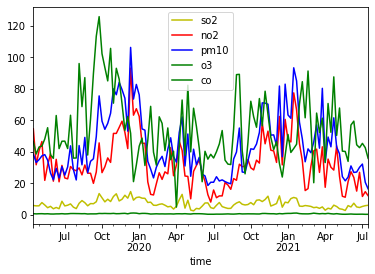

In [45]:
## 一周内的重采样和计算平均值
data_knn.so2.resample('W').mean().plot(color='y', legend=True)
data_knn.no2.resample('W').mean().plot(color='r', legend=True)
data_knn.pm10.resample('W').mean().plot(color='b', legend=True)
data_knn.o3.resample('W').mean().plot(color='g', legend=True)
data_knn.co.resample('W').mean().plot(color='g', legend=True)
plt.show()

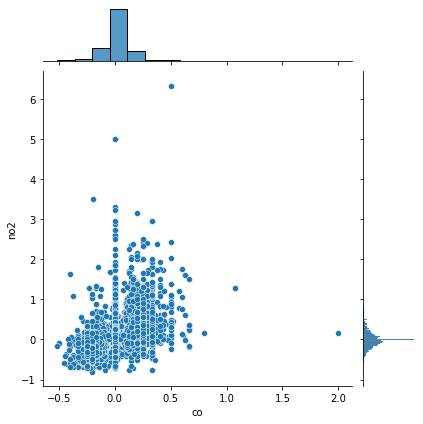

In [46]:
###Global_intensity', 'Global_active_power'之间的相关性
data_returns = data_knn.pct_change()
sns.jointplot(x='co', y='no2', data=data_returns)  

plt.show()

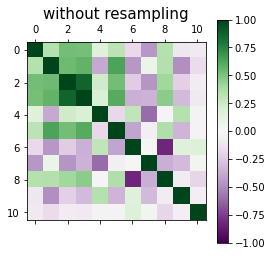

In [47]:
# 各特征间的相关性，颜色越深，相关性越大
plt.matshow(data_knn.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

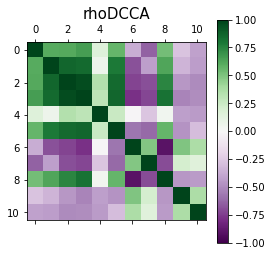

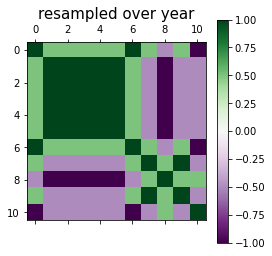

In [49]:
# 几个月内重新采样的特征平均值的相关性

plt.matshow(data_knn.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('rhoDCCA', size=15)
plt.colorbar()
plt.margins(0.02)
#plt.savefig( r'C:\Users\zzsgdsg7\Desktop\zaojia1.pdf')
plt.matshow(data_knn.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

* 从上面可以看出，使用重采样技术可以改变特征之间的相关性。这对于特征工程非常重要。¶
* ##机器学习：Lstm-Attention数据准备和特征工程
* 在给定当前时间（t）的预测到Global_Active_Power测量和其他时间步骤中的其他功能，搭建监督学习问题算法。

In [51]:
#将序列转为监督学习序列数据
'''
    将时间序列重构为监督学习数据集.
	参数:
		data: 观测值序列，类型为列表或Numpy数组。
		n_in: 输入的滞后观测值(X)长度。
		n_out: 输出观测值(y)的长度。
		dropnan: 是否丢弃含有NaN值的行，类型为布尔值。
	返回值:
		经过重组后的Pandas DataFrame序列.
    '''
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [52]:
## * Note: 归一化数据范围为0-1.
values =data_knn.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)
reframed.info()
# 去掉不想预测的列
reframed.drop(reframed.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19431 entries, 1 to 19431
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   var1(t-1)   19431 non-null  float32
 1   var2(t-1)   19431 non-null  float32
 2   var3(t-1)   19431 non-null  float32
 3   var4(t-1)   19431 non-null  float32
 4   var5(t-1)   19431 non-null  float32
 5   var6(t-1)   19431 non-null  float32
 6   var7(t-1)   19431 non-null  float32
 7   var8(t-1)   19431 non-null  float32
 8   var9(t-1)   19431 non-null  float32
 9   var10(t-1)  19431 non-null  float32
 10  var11(t-1)  19431 non-null  float32
 11  var1(t)     19431 non-null  float32
 12  var2(t)     19431 non-null  float32
 13  var3(t)     19431 non-null  float32
 14  var4(t)     19431 non-null  float32
 15  var5(t)     19431 non-null  float32
 16  var6(t)     19431 non-null  float32
 17  var7(t)     19431 non-null  float32
 18  var8(t)     19431 non-null  float32
 19  var9(t)     19431 non-nul

将其余数据拆分为训练集和验证集
* 首先，我将准备好的数据集拆分为训练集和测试集。为了加快模型的训练（为了演示），我们只会在第一年的数据上训练模型，然后在接下来的三年的数据上评估它¶

In [58]:
# 划分数据集
values = reframed.values
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
#这里只做了演示取1年的数据训练，效果不是那么好。
n_train_time = 8760#365*24#以一年数据训练，
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(8760, 1, 11) (8760,) (10671, 1, 11) (10671,)


构建LSTM-Attention模型
1) LSTM 隐藏层100
2) Attention为自注意力机制
3) dropout 层20%
4) 1个神经元在输出层中，用于预测Global_Active_Power。
5) 输入形状为1个时间步长，有7个特征
6)使用了平均绝对误差（MAE）损失函数和随机梯度下降的有效Adam。
7) epochs=20, batch size = 70.

Train on 8760 samples, validate on 10671 samples
Epoch 1/100
8760/8760 - 1s - loss: 0.0061 - val_loss: 0.0034
Epoch 2/100
8760/8760 - 0s - loss: 0.0051 - val_loss: 0.0030
Epoch 3/100
8760/8760 - 0s - loss: 0.0047 - val_loss: 0.0029
Epoch 4/100
8760/8760 - 0s - loss: 0.0044 - val_loss: 0.0029
Epoch 5/100
8760/8760 - 0s - loss: 0.0043 - val_loss: 0.0029
Epoch 6/100
8760/8760 - 0s - loss: 0.0043 - val_loss: 0.0029
Epoch 7/100
8760/8760 - 0s - loss: 0.0042 - val_loss: 0.0028
Epoch 8/100
8760/8760 - 0s - loss: 0.0041 - val_loss: 0.0028
Epoch 9/100
8760/8760 - 0s - loss: 0.0040 - val_loss: 0.0027
Epoch 10/100
8760/8760 - 0s - loss: 0.0040 - val_loss: 0.0027
Epoch 11/100
8760/8760 - 0s - loss: 0.0039 - val_loss: 0.0026
Epoch 12/100
8760/8760 - 0s - loss: 0.0039 - val_loss: 0.0026
Epoch 13/100
8760/8760 - 0s - loss: 0.0039 - val_loss: 0.0025
Epoch 14/100
8760/8760 - 0s - loss: 0.0038 - val_loss: 0.0024
Epoch 15/100
8760/8760 - 0s - loss: 0.0038 - val_loss: 0.0024
Epoch 16/100
8760/8760 - 0s - 

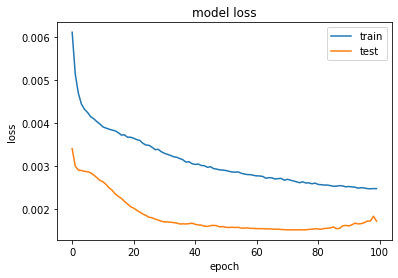

Test RMSE: 1.776


In [59]:
#网络结构
inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))  # 构建输入的大小，即张量
lstm_layer = LSTM(100,input_shape=(train_X.shape[1], train_X.shape[2]))(inputs)
attention_layer=Attention()([lstm_layer,lstm_layer])
dp=Dropout(0.2)(attention_layer)
out_layer = Dense(1, activation='linear')(dp)  #
model = Model(inputs=inputs, outputs=out_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# 显示训练的loss值情况
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.savefig( r'C:\Users\zzsgdsg7\Desktop\zaojia2.pdf')
plt.show()

# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 11))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:, -10:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -10:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

请注意，为了改进模型，必须调整epoch和Batch_size等超参数

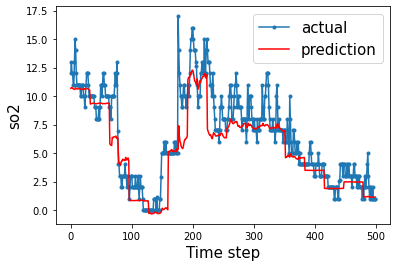

In [61]:
## 时间步长，每个步长为一小时（您可以轻松地将时间步长转换为实际时间索引）
## 为了演示，我只比较了200小时内的预测. 
#显示预测结果
aa=[x for x in range(500)]
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel('so2', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig( r'C:\Users\zzsgdsg7\Desktop\zaojia3.pdf')
plt.show()